# 1. 모듈 임포트 및 변수 설정
## epochs 변경(25 -> 12)

In [1]:
# 모듈 임포트

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 변수 생성

    # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

    # 이미지 사이즈 
IMAGE_SIZE = [180, 180]

    # 데이터 경로
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

    # 배치 사이즈 및 에포크
BATCH_SIZE = 16
EPOCHS = 12

print(ROOT_PATH)


/aiffel/aiffel


# 2. 데이터 가져오기
## augmentation 도입

In [3]:
# 데이터 로드 및 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))




5216
624
16


In [4]:
# train과 val 데이터 합친 후 train:val를 8:2로 분할

    # train, val 합치기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

    # 합친 데이터 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
    

4185
1047


In [5]:
# train 데이터 안 정상 이미지 및 폐렴 이미지 수 확인 및 변수 할당

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

print("---------------------------------------------------")

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg
---------------------------------------------------
Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
# tf.data 인스턴스 만들기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# train set, val set 개수 확인 및 변수 할당

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 이미지 라벨 생성(함수 생성)


def get_label(file_path):
    # 파일 경로 쪼개기
    parts = tf.strings.split(file_path, os.path.sep)
    # 폐렴이면 양성(True), 노말이면 음성(False)
    return parts[-2] == 'PNEUMONIA'

In [9]:
# 이미지 전처리 함수 생성(형식 및 사이즈 통일)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


In [10]:
# (함수 활용) train 및 validation 데이터셋 만들기 

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 리사이즈 및 라벨 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [11]:
# (함수 활용) Test 데이터셋 만들기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
# augmentation 도입
# tf.data 파이프라인 활용해서 학습 데이터 사용 효율 높이기

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

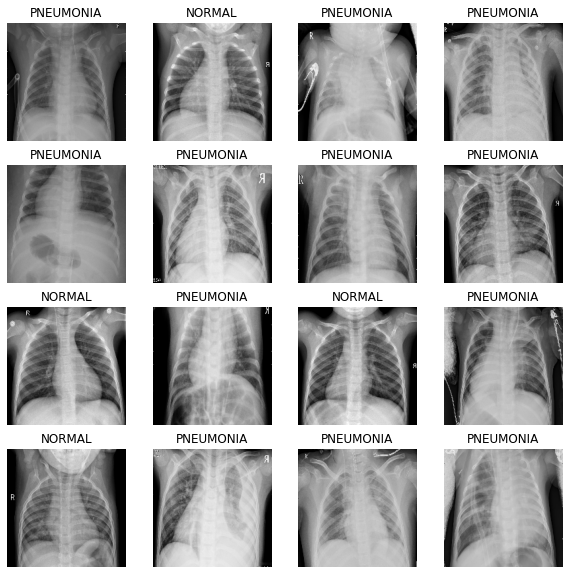

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

## Convolution layer 및 Dense layer 각각 1개 층씩 추가
## Dropout 비율 조정(0.2 -> 0.3) 

In [14]:
# convolution block 만들기

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block



In [15]:
# Dense Block 만들기

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
# CNN 모델 만들기

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(1024, 0.8),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [17]:
# 가중치 설정(데이터 양과 반비례)

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [19]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE, 
        epochs=EPOCHS,
        validation_data=val_ds, 
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/12
261/261 [==============================] - 64s 193ms/step - loss: 0.8515 - accuracy: 0.5110 - precision: 0.7662 - recall: 0.4936 - val_loss: 0.8631 - val_accuracy: 0.2635 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/12
261/261 [==============================] - 50s 192ms/step - loss: 0.7376 - accuracy: 0.5522 - precision: 0.7987 - recall: 0.5317 - val_loss: 0.7766 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/12
261/261 [==============================] - 50s 191ms/step - loss: 0.3683 - accuracy: 0.8144 - precision: 0.9554 - recall: 0.7871 - val_loss: 0.2788 - val_accuracy: 0.8731 - val_precision: 0.8552 - val_recall: 0.9961
Epoch 4/12
261/261 [==============================] - 50s 193ms/step - loss: 0.2851 - accuracy: 0.8867 - precision: 0.9647 - recall: 0.8799 - val_loss: 0.8934 - val_accuracy: 0.7490 - val_precision: 0.9980 - val_recall: 0.6601
Epoch 5/12
261/261 [==============================] - 52s 198ms/step - loss:

# 7. 결과 확인

## 정확도 87%로 예제 대비 7% 상승

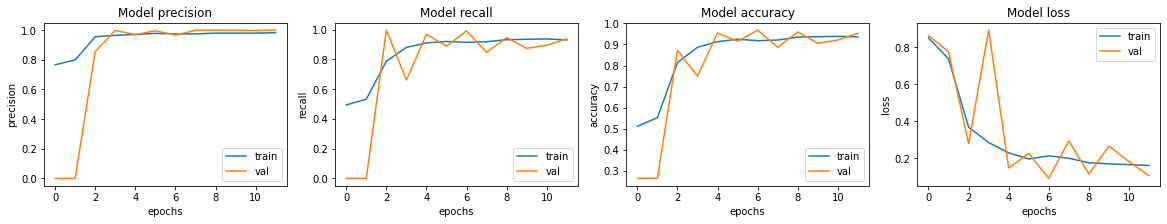

In [20]:
# 학습결과 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
# 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.3608 - accuracy: 0.8702 - precision: 0.8601 - recall: 0.9462
Loss: 0.36081498861312866,
Accuracy: 0.870192289352417,
Precision: 0.8601398468017578,
Recall: 0.9461538195610046
